# Анализ отзывов на банки

В данных представлены отзывы на банки с сайта [banki.ru](https://www.banki.ru/)
- body - сам отзыв
- title - название отзыва
- rating - оценка по отзыву, варьируется от 1 до 5
- bank_name - название банка
- date - дата публикации отзыва

Проведен EDA (Exploratory Data Analysis) по этим данным и построен бинарный классификатор отзывов. Отзывы от 3 баллов считаем положительными.

# Для начала загрузим все нужные библиотеки

In [ ]:
!pip install pymorphy2
!pip install transformers==3.1.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import seaborn as sns

import time

from collections import Counter
from collections import defaultdict

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support

import string
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
russian_stopwords = stopwords.words("russian")
from string import punctuation
import pymorphy2
from nltk.stem import SnowballStemmer
snowball = SnowballStemmer(language="russian")
from pymystem3 import Mystem
mystem = Mystem() 

from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Считаем данные и проведем разведочный анализ данных (EDA)

In [ ]:
df = pd.read_csv('data.csv.gz')   # можно поменять, если фйл распакованный

print('Число строк и столбцов в наборе данных:\n', df.shape)

Число строк и столбцов в наборе данных:
 (92735, 5)


In [ ]:
df.sort_values('date')

,body,title,rating,bank_name,date
92734,Хочется выразить благодарность всему коллектив...,Рекомендуемый мной банк,5,Точка,2022-09-02 11:28:11
92733,9.08.22 оформлен кредит на покупку автомобиля ...,Штрафные санкции,1,Драйв Клик Банк,2022-09-02 11:28:32
92732,В августе 2021 я досрочно погасил ипотеку (кре...,Снятие обременения с квартиры,2,Россельхозбанк,2022-09-02 11:34:34
92731,Обратился с вопросом (6908609) по All Airlines...,Отличная консультация от сотрудника поддержки,5,Тинькофф Банк,2022-09-02 11:46:24
92730,"30 августа обнаружила, что баланс уменьшился. ...",Банк списал деньги и теперь рекомендует их сам...,1,Совкомбанк,2022-09-02 11:47:44
...,...,...,...,...,...
4,&lt;p&gt;Увидела на сайте Газпромбанка акцию с...,Как Газпромбанк обманывает клиентов с акционны...,1,Газпромбанк,2023-01-03 12:12:36
3,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07
2,&lt;p&gt;07.09.22 ю была оформлена кредитная к...,"Ошибочное начисление комиссии, затягивание про...",1,Банк Открытие,2023-01-03 12:23:11
1,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46


Следовательно, мы рассматриваем период с 2.09.2022 по 3.01.2023

### Немного предобработаем данные

In [ ]:
df.isna().sum()+df.isna().sum()

body         0
title        0
rating       0
bank_name    0
date         0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92735 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92735 non-null  object
 1   title      92735 non-null  object
 2   rating     92735 non-null  int64 
 3   bank_name  92735 non-null  object
 4   date       92735 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.5+ MB


In [ ]:
len(df)- len(df.drop_duplicates())

62

In [ ]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 92673 entries, 0 to 92734
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       92673 non-null  object
 1   title      92673 non-null  object
 2   rating     92673 non-null  int64 
 3   bank_name  92673 non-null  object
 4   date       92673 non-null  object
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


Как видим, дубликатов оказалось не так много

### Немного визуализируем данные с датасета

Посмотрим на распределение рейтингов:

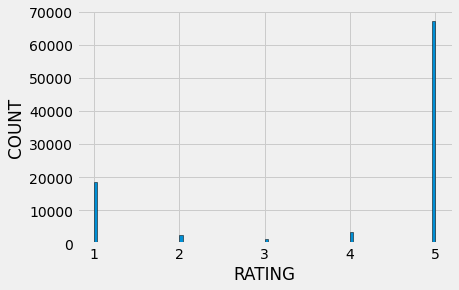

In [ ]:
plt.style.use('fivethirtyeight')
plt.hist(df['rating'].dropna(), bins = 100, edgecolor = 'k');
plt.xlabel('RATING'); plt.ylabel('COUNT'); 

А также посмотрим на графике boxplot квантили 25/50/75 длины отзыва в зависимости от поставленной оценки

In [ ]:
df['word_number'] = df['body'].apply(lambda x: len(str(x).split(' ')))
df['word_number'].describe()

count    92673.000000
mean        90.768757
std         76.911340
min          1.000000
25%         48.000000
50%         61.000000
75%        100.000000
max        704.000000
Name: word_number, dtype: float64

В датасете в основном тексты со средней длиной 91 слово

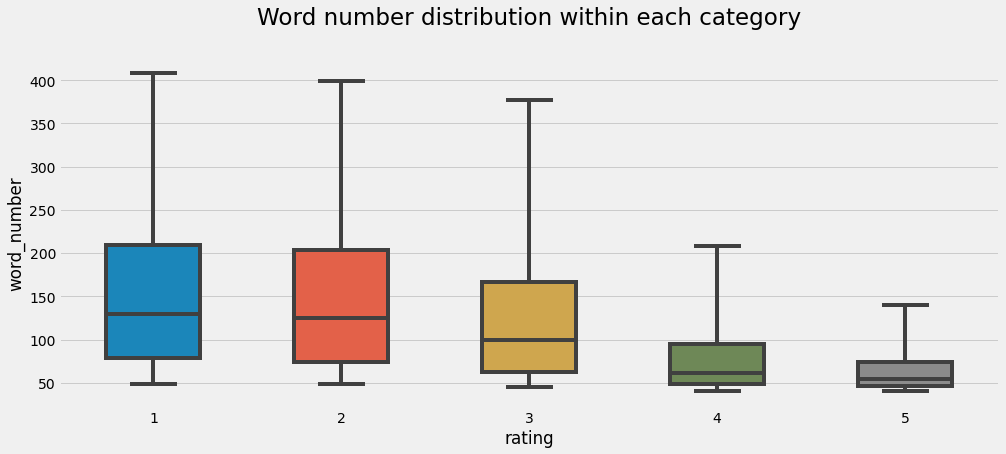

In [ ]:
plt.figure(figsize=(15,6))
sns.boxplot(data=df, x='rating', y='word_number', width=.5, showfliers=False, whis=[5,95])
plt.title('Word number distribution within each category', fontsize = 23, pad = 33)
plt.show()

Выводы: 

1)классы рейтинга сильно не сбалансированы, в основном оставляют оценки 5

2)негативные отзывы, как правило, длиннее положительных

Следующий код показывает, что разбалансировка происходит по большей части из-за отзывов о следующих банках: Тинькофф, Совкомбанк, Модульбанк, Открытие, Россельхозбанк, Московский Кредитный Банк, Азиатско-Тихоокеанский Банк

In [ ]:
flag1 = 0
flag2 = 0
for name in df['bank_name'].unique():
  filter1 = df['bank_name'] == name
  for rat in df['rating'].unique():
    filter2 = df['rating'] == rat
    df_0 = df.loc[filter1&filter2]
    l = df_0.shape[0]
    if (df.shape[0] > 2000):
      if ((rat == 5) & (l > 900)):
        flag1 = 1
      if ((rat != 5) & (l < 500)):
        flag2 = 1
      elif ((rat != 5) & (l > 500) & (name != 'Тинькофф Банк')):
        flag2 = 0
        # break
  if (flag1 & flag2 & (name != 'СберБанк')):
    print(name, ':')
    print('1 балл:', df[(df['rating']==1) & filter1].shape[0])
    print('2 балла:', df[(df['rating']==2) & filter1].shape[0])
    print('3 балла:', df[(df['rating']==3) & filter1].shape[0])
    print('4 балла:', df[(df['rating']==4) & filter1].shape[0])
    print('5 баллов:', df[(df['rating']==5) & filter1].shape[0])
  flag1 = 0
  flag2 = 0

Тинькофф Банк :
1 балл: 1849
2 балла: 306
3 балла: 161
4 балла: 1069
5 баллов: 41467
Банк Открытие :
1 балл: 580
2 балла: 85
3 балла: 42
4 балла: 100
5 баллов: 1087
Совкомбанк :
1 балл: 943
2 балла: 110
3 балла: 82
4 балла: 223
5 баллов: 4742
Модульбанк :
1 балл: 58
2 балла: 6
3 балла: 6
4 балла: 59
5 баллов: 1323
Россельхозбанк :
1 балл: 368
2 балла: 53
3 балла: 11
4 балла: 14
5 баллов: 2616
Московский Кредитный Банк :
1 балл: 201
2 балла: 34
3 балла: 16
4 балла: 11
5 баллов: 987
Азиатско-Тихоокеанский Банк :
1 балл: 60
2 балла: 9
3 балла: 5
4 балла: 5
5 баллов: 921


### Теперь посчитатем топ-15 банков по кол-ву отзывов

In [ ]:
df_top_15_count_otz = df.groupby('bank_name').count().sort_values('body', ascending=False)[0:15]
df_top_15_count_otz

,body,title,rating,date,word_number
bank_name,,,,,
Тинькофф Банк,44852,44852,44852,44852,44852
Хоум Кредит Банк,9301,9301,9301,9301,9301
Совкомбанк,6100,6100,6100,6100,6100
ВТБ,3814,3814,3814,3814,3814
СберБанк,3487,3487,3487,3487,3487
Альфа-Банк,3368,3368,3368,3368,3368
Россельхозбанк,3062,3062,3062,3062,3062
Банк Открытие,1894,1894,1894,1894,1894
МТС Банк,1542,1542,1542,1542,1542


Соответственно, выше приведен список из 15 самых частовречающихся банков в наших данных

Визуализируем это распредление отзывов:

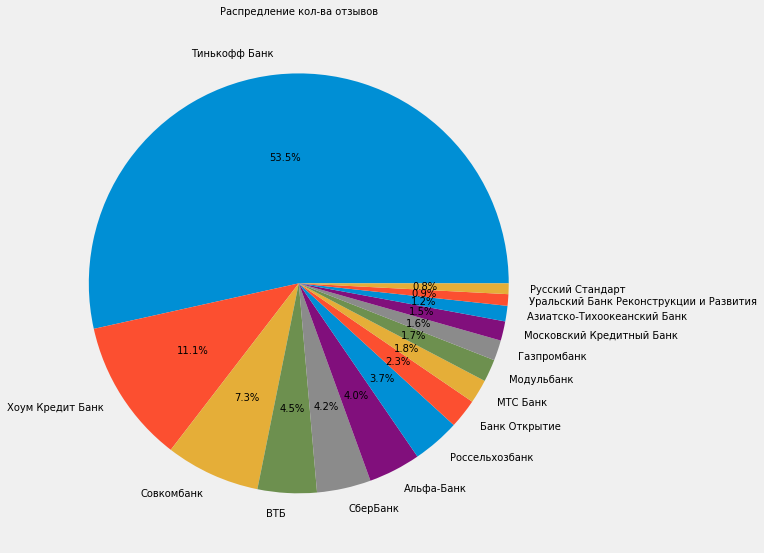

In [ ]:
top_15_name = df_top_15_count_otz.index
df_top_15 = df[df['bank_name'].isin(top_15_name)]
name_rasp=df_top_15.value_counts(df_top_15['bank_name'])
plt.figure(figsize=(9, 9))
plt.pie(name_rasp, labels = name_rasp.index, autopct='%1.1f%%', textprops={'fontsize': 10})
plt.title('Распредление кол-ва отзывов', fontsize=10)
plt.show()

То есть больше половины отзывов о Тинькоффе :)

### Выясним, какой банк из числа топ-15 по отзывов имеет самый высокий средний рейтинг?

In [ ]:
top_15_name = top_15_name.drop('Тинькофф Банк')

df_top_15 = df[df['bank_name']=='Тинькофф Банк']

for name in df['bank_name'].unique():
  if name in top_15_name:
    df_top_15 = np.append(df_top_15, df[df['bank_name']==name], axis = 0)

df_top_15 = pd.DataFrame(df_top_15)
df_top_15.columns = ['body', 'title', 'rating', 'bank_name', 'date', 'word_number']

df_top_15

,body,title,rating,bank_name,date,word_number
0,&lt;p&gt;При возврате просроченной задолженнос...,Возврат просроченной задолженномти,1,Тинькофф Банк,2023-01-03 12:31:46,60
1,&lt;p&gt;Новый год начинается с приятностей)&l...,Клиентоориентиванность 10 из 10,5,Тинькофф Банк,2023-01-03 12:16:07,149
2,&lt;p&gt;Мне очень понравился тинькофф и как о...,Хороший банк,5,Тинькофф Банк,2023-01-03 11:58:32,161
3,"&lt;p&gt;В очередной раз убедился,что Тинькофф...",Тинькофф всегда платит!,5,Тинькофф Банк,2023-01-03 11:47:07,129
4,&lt;p&gt;От банка поступило предложение обнови...,Высокое качество поддержки клиентов,5,Тинькофф Банк,2023-01-03 11:40:05,44
...,...,...,...,...,...,...
83865,"Когда-то была открыта кредитная карта ,на кото...",Досрочное погашение,5,Русский Стандарт,2022-09-02 15:23:04,37
83866,"Отличный специалист. Огромнре спасибо за то, ...",Банковские услуги,5,Русский Стандарт,2022-09-02 14:39:48,40
83867,"Здравствуйте, хочу поблагодарить сотрудницу А-...",Благодарность,5,Русский Стандарт,2022-09-02 14:32:49,38
83868,Ужасный банк не соблюдающий договоренность.\r\...,Оплата по графику оплаты,1,Русский Стандарт,2022-09-02 14:31:35,163


In [ ]:
df_top_1_mean_otz = df_top_15.groupby('bank_name').mean().sort_values('rating', ascending=False)[0:1] 
df_top_1_mean_otz

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  exec(code_obj, self.user_global_ns, self.user_ns)


,rating,word_number
bank_name,,
Тинькофф Банк,4.783622,70.624409


Вывод: Из топ-15 банков по отзывам самый высокий рейтинг по Тинькоффа - 4,78

### Выводы об изменении среднего рейтинга банков по месяцам из топ-5 банков по числу отзывов:

Исходя из предыдущих выводов, топ 5 банков по числу отзывов: Тинькофф Банк, Хоум Кредит Банк, Совкомбанк, ВТБ, СберБанк

In [ ]:
top_5_bank_name = ['Тинькофф Банк', 'Хоум Кредит Банк', 'Совкомбанк', 'ВТБ', 'СберБанк']

Введем новую категориальную переменную - месяц (а точнее номер месяца)

In [ ]:
df_top_5 = df[(df['bank_name'] == 'Тинькофф Банк') | (df['bank_name'] == 'Хоум Кредит Банк') | (df['bank_name'] == 'Совкомбанк') | (df['bank_name'] == 'ВТБ') | (df['bank_name'] == 'СберБанк')]
df_top_5 = df_top_5.drop(['body', 'title'], axis = 1)
df_top_5

,rating,bank_name,date,word_number
1,1,Тинькофф Банк,2023-01-03 12:31:46,60
3,5,Тинькофф Банк,2023-01-03 12:16:07,149
6,1,ВТБ,2023-01-03 12:04:02,43
8,5,Тинькофф Банк,2023-01-03 11:58:32,161
9,1,Хоум Кредит Банк,2023-01-03 11:47:17,119
...,...,...,...,...
92727,5,Тинькофф Банк,2022-09-02 11:52:26,49
92728,1,СберБанк,2022-09-02 11:49:06,55
92729,1,ВТБ,2022-09-02 11:48:32,90
92730,1,Совкомбанк,2022-09-02 11:47:44,147


In [ ]:
df_top_5_01 = df_top_5[df_top_5['date'].str.contains('-01-')]
df_top_5_09 = df_top_5[df_top_5['date'].str.contains('-09-')]
df_top_5_10 = df_top_5[df_top_5['date'].str.contains('-10-')]
df_top_5_11 = df_top_5[df_top_5['date'].str.contains('-11-')]
df_top_5_12 = df_top_5[df_top_5['date'].str.contains('-12-')]

series_month_1 = pd.DataFrame([1]*len(df_top_5_01))
series_month_9 = pd.DataFrame([9]*len(df_top_5_09))
series_month_10 = pd.DataFrame([10]*len(df_top_5_10))
series_month_11 = pd.DataFrame([11]*len(df_top_5_11))
series_month_12 = pd.DataFrame([12]*len(df_top_5_12))

series_month = pd.concat([series_month_1, series_month_9, series_month_10, series_month_11, series_month_12], axis = 0)

In [ ]:
series_month

,0
0,1
1,1
2,1
3,1
4,1
...,...
21272,12
21273,12
21274,12
21275,12


In [ ]:
df_top_5 = df_top_5.reset_index()
series_month = series_month.reset_index()

df_top_5 = pd.concat([df_top_5, series_month], axis = 1)
df_top_5 = df_top_5.drop('index', axis = 1)

df_top_5.rename(columns = {0:'month'}, inplace = True )
df_top_5 = df_top_5.drop('date', axis = 1)

df_top_5

,rating,bank_name,word_number,month
0,1,Тинькофф Банк,60,1
1,5,Тинькофф Банк,149,1
2,1,ВТБ,43,1
3,5,Тинькофф Банк,161,1
4,1,Хоум Кредит Банк,119,1
...,...,...,...,...
67549,5,Тинькофф Банк,49,12
67550,1,СберБанк,55,12
67551,1,ВТБ,90,12
67552,1,Совкомбанк,147,12


Немного визуализируем разброс категорий

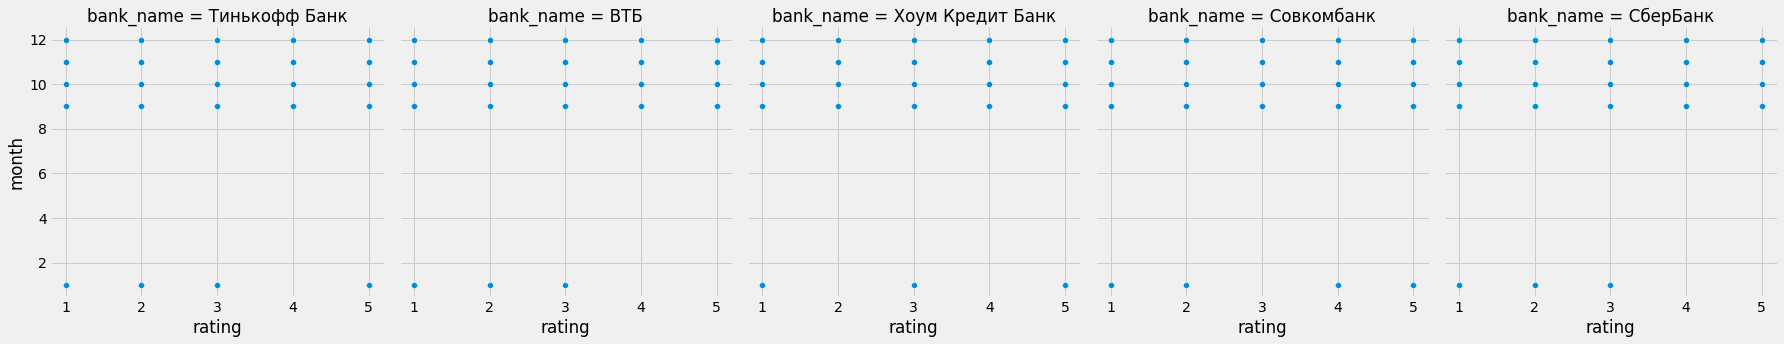

In [ ]:
sns.relplot(x = 'rating', y = 'month', col = 'bank_name', data = df_top_5);

Исследуем изменениу среднего рейтинга банков по месяцам

In [ ]:
series_rating_mean = []
series_rating_count = []
for name in df_top_5['bank_name'].unique():
  filter1 = df_top_5['bank_name']==name
  for mon in df_top_5['month'].unique():
    print(name, ':', mon)
    filter2 = df_top_5['month']==mon
    df_0 = df_top_5.loc[filter1&filter2]
    series_rating_mean += [df_0['rating'].mean()]
    series_rating_count += [df_0['rating'].count()]
  series_rating_mean += ['-------------']
  series_rating_count += ['-------------']

#print делаю просто чтобы понимать порядок  

Тинькофф Банк : 1
Тинькофф Банк : 9
Тинькофф Банк : 10
Тинькофф Банк : 11
Тинькофф Банк : 12
ВТБ : 1
ВТБ : 9
ВТБ : 10
ВТБ : 11
ВТБ : 12
Хоум Кредит Банк : 1
Хоум Кредит Банк : 9
Хоум Кредит Банк : 10
Хоум Кредит Банк : 11
Хоум Кредит Банк : 12
Совкомбанк : 1
Совкомбанк : 9
Совкомбанк : 10
Совкомбанк : 11
Совкомбанк : 12
СберБанк : 1
СберБанк : 9
СберБанк : 10
СберБанк : 11
СберБанк : 12


In [ ]:
series_rating_mean

[3.9902912621359223,
 4.143356643356643,
 4.754267216009417,
 4.865583371612311,
 4.763988746483276,
 '-------------',
 1.1481481481481481,
 1.8657407407407407,
 1.9614325068870524,
 1.9670691547749726,
 1.9749077490774907,
 '-------------',
 2.8333333333333335,
 4.417185554171856,
 4.631504922644163,
 4.006932409012132,
 3.8598247809762203,
 '-------------',
 4.419354838709677,
 4.585412667946257,
 4.51003687013519,
 4.01453790238837,
 3.833025261860752,
 '-------------',
 1.4,
 1.664021164021164,
 2.077764277035237,
 2.6507936507936507,
 2.431229235880399,
 '-------------']

In [ ]:
series_rating_count

[103,
 1144,
 10194,
 17416,
 15995,
 '-------------',
 27,
 432,
 1089,
 911,
 1355,
 '-------------',
 12,
 803,
 7110,
 577,
 799,
 '-------------',
 31,
 1042,
 2441,
 963,
 1623,
 '-------------',
 25,
 378,
 823,
 756,
 1505,
 '-------------']

Выводы: отзывы за предоставленный период говорят о том, что к концу нового года средний рейтинш понизился у Тинькоффа, ВТБ, Хоум Кредит Банка, СберБанка и повысился у Совкомбанка При чем за сентябрь отзывы практически отсутствуют, н их количество резко возрастает к новому году

# Построение бинарного классификатора

Я решила задачу с помощью преобразования TF-IDF и модели логистической регрессии

(Для методов и алгоритмов NLP мне не хватило gpu, поэтому оставила только классический ML)

Так как нам нужен именно бинарный классификатор, заменим значения рейтинга от 0 до 5 на good и bad:

In [ ]:
df = df.sort_values('rating')

len_good = df[df['rating'] >= 4].shape[0]
len_bad = df[df['rating'] < 4].shape[0]

df['rating'] = ['bad']*len_bad + ['good']*len_good

df

,body,title,rating,bank_name,date,word_number
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,Заблокировали средства,bad,Еком Банк,2023-01-03 12:46:11,65
21689,"Оформил автокредит в интернет банке, все прошл...",Не получайте оформить залог по автокредиту онлайн,bad,ВТБ,2022-12-08 15:55:39,164
78019,&lt;p&gt;В конце июля в приложении Альфа-банка...,Комиссия за организацию страхования,bad,Альфа-Банк,2022-10-19 15:48:00,86
78023,&lt;p&gt;На днях искал возможность получить кр...,Кредит самозанятым,bad,Россельхозбанк,2022-10-19 15:40:27,86
21681,23 ноября я обратилась в отделение банка по ад...,Банк нарушает закон и не выполняет обязательст...,bad,МТС Банк,2022-12-08 16:02:19,301
...,...,...,...,...,...,...
36844,"&lt;p&gt;Пришло увеомление от альфа банка, что...",Курьер напомнил про плату за смс уведомления,good,Альфа-Банк,2022-11-21 10:17:00,101
36841,&lt;p&gt;12.11.2022 совершал покупку товара и ...,Решение трудности,good,Банк Открытие,2022-11-21 10:23:54,53
36839,&lt;p&gt;Доброго времени суток. хочу вам порек...,Обслуживание,good,Тинькофф Банк,2022-11-21 10:25:17,39
36835,Здравствуйте! Возникла необходимость перевести...,Денежный перевод,good,Азиатско-Тихоокеанский Банк,2022-11-21 10:34:51,43


Исследуем распределение классов

In [ ]:
df['rating'].value_counts()

good    70666
bad     22007
Name: rating, dtype: int64

Как видно, датасет сильно несбалансирован в стоорону класса 'good'

Теперь интересно посмотреть, какие слова пользователи в основном используют в каждом классе

Для этого необходимо предварительно почистить текст (удалить стоп слова, символы, пунктуацию и удалить слова состоящие из одной буквы)

In [ ]:
def preprocess_text(text):     #функция очистки текста

    tokens = str(text).split()
    tokens = [token for token in tokens if token not in russian_stopwords]
    
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    tokens = [re_punc.sub('', w) for w in tokens]
    tokens = [word for word in tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word) > 1]
    text = " ".join(tokens)
    
    return text

In [ ]:
df['body'] = df['body'].apply(preprocess_text)

good = df[df['rating'] == 'good']['body']
bad = df[df['rating'] == 'bad']['body']

In [ ]:
def occur(doc):      #функция для фильтрации слов с заданным вхождением
    vocab = Counter()
    for sent in doc:
        vocab.update(str(sent).split())
    tokens = [k for k,c in vocab.items() if c >= 5000]
    return ' '.join(str(i) for i in tokens)


tokens_good = occur(good)
tokens_bad = occur(bad)

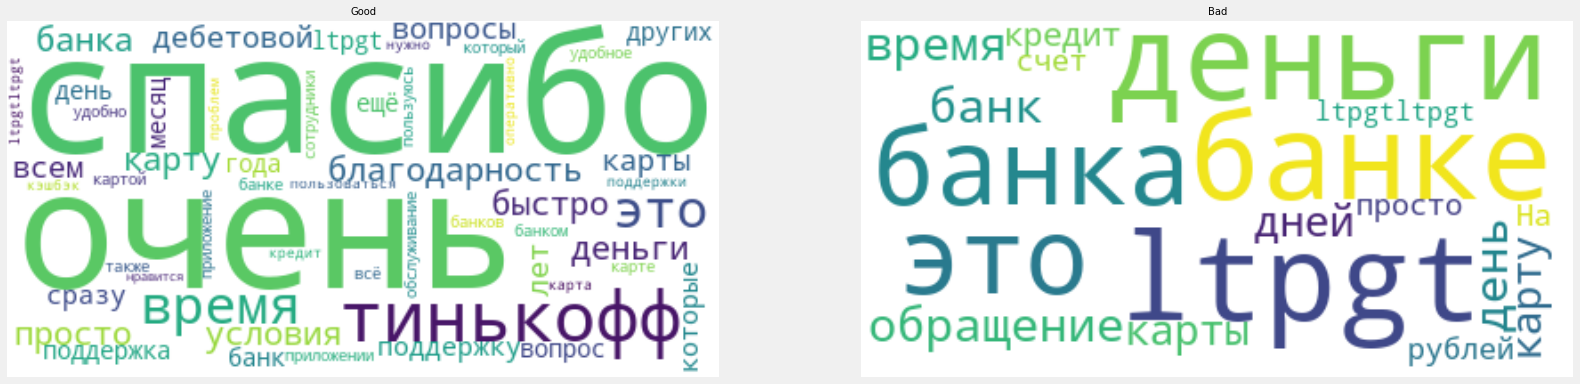

In [ ]:
wordcloud = WordCloud(background_color="white",max_words=len(tokens_good)).generate(tokens_good)
wordcloud1 = WordCloud(background_color="white",max_words=len(tokens_bad)).generate(tokens_bad)


fig, ax = plt.subplots(1, 2, figsize=(25,10))


ax[0].imshow(wordcloud, interpolation='bilinear')
ax[1].imshow(wordcloud1, interpolation='bilinear')


ax[0].axis("off")
ax[0].set_title('Good', fontsize="10",  y=1)
ax[1].axis("off")
ax[1].set_title('Bad', fontsize="10",  y=1)


# plt.subplots_adjust(wspace=0.05, hspace=-0.5)
plt.show()

In [ ]:
filename = 'data.csv.gz' 

In [ ]:
def Load_Transform_Data(filename): #извлечение и трансформация данных
    #Loading data
    filename = [filename]
    concat_text = pd.DataFrame()
    raw_text = pd.read_csv(filename[0],usecols=[0])#аттрибут с текстом 'body'
    raw_target = pd.read_csv(filename[0],usecols=[2])#аттрибут классов 'rating'
    
    concat_text = pd.concat([raw_text, raw_target], axis=1)
    
    concat_text = concat_text.dropna().reset_index(drop = True)#удаляем пустые отзывы
  

    return concat_text

In [ ]:
data = Load_Transform_Data(filename)

data = data.sort_values('rating')

len_good = data[data['rating'] >= 4].shape[0]
len_bad = data[data['rating'] < 4].shape[0]

data['rating'] = ['bad']*len_bad + ['good']*len_good

data

,body,rating
0,&lt;p&gt;Добрый день&lt;/p&gt;\r\n&lt;p&gt;пиш...,bad
13720,&lt;p&gt;с октября месяца не могу разблокирова...,bad
52723,"&lt;p&gt;Здравствуйте, 24.10.22г. пенсионерка ...",bad
52738,&lt;p&gt;Не ходите в Почта банк. Не делайте у ...,bad
52749,&lt;p&gt;Открыл накопительный счет под 9%. Сот...,bad
...,...,...
46371,&lt;p&gt;Я пользуюсь дебетовой картой от Тиньк...,good
46372,&lt;p&gt;Пользуюсь около двух лет еще ни раз н...,good
46373,&lt;p&gt;Пользуюсь картой более двух лет и мог...,good
46359,&lt;p&gt;Недавно друг посоветовал мне карту Ти...,good


Мы сбалансируем данные методом undersampling, сделав количество каждого класса равным 22025, то есть равным кол-ву класса негативных отзывов

In [ ]:
balanced_df=data.groupby('rating',as_index = False,group_keys=False).apply(lambda s: s.sample(22025,replace=True))

balanced_df['rating'].value_counts()

bad     22025
good    22025
Name: rating, dtype: int64

In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44050 entries, 77798 to 75184
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   body    44050 non-null  object
 1   rating  44050 non-null  object
dtypes: object(2)
memory usage: 1.0+ MB


чистим датасет

In [ ]:
balanced_df['body'] = balanced_df['body'].apply(preprocess_text)

Делим датасет на обучающую и тестовую выборки в пропорции 70/30



In [ ]:
X_train, X_test, y_train, y_test = train_test_split(balanced_df['body'], balanced_df['rating'], random_state = 42, test_size = 0.3)

##### TF-IDF+Log regression

In [ ]:
pipe = Pipeline([
    ('vec', TfidfVectorizer()),
    ('clf', LogisticRegression(C=10, max_iter=7000)),
     ])

In [ ]:
model = pipe.fit(X_train, y_train)

In [ ]:
print("Accuracy of Logistic regression Classifier is {}".format(model.score(X_test,y_test)))

Accuracy of Logistic regression Classifier is 0.9800983730609156


Test dataset accuracy score: 0.9800983730609156 

              precision    recall  f1-score   support

        good       0.99      0.97      0.98      6569
         bad       0.97      0.99      0.98      6646

    accuracy                           0.98     13215
   macro avg       0.98      0.98      0.98     13215
weighted avg       0.98      0.98      0.98     13215



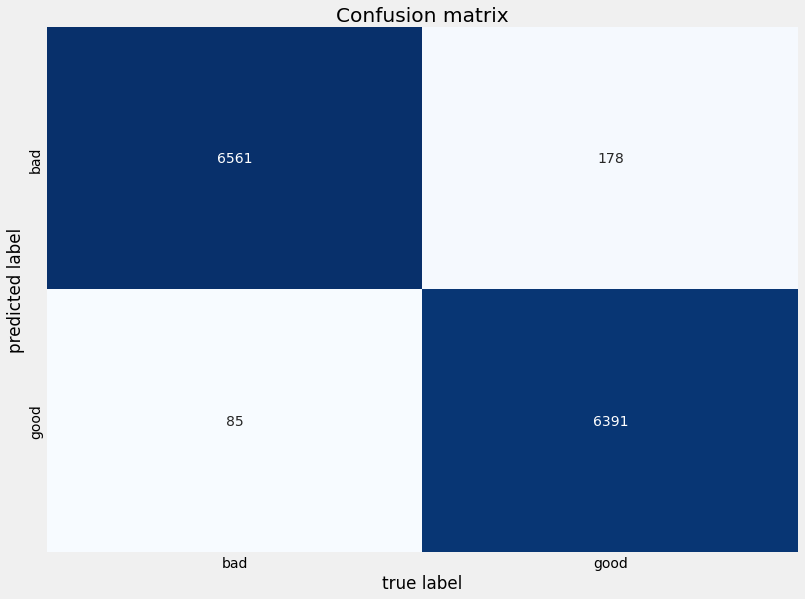

In [ ]:
labels = list(set(data['rating']))

#prediction on the cleaned test dataset
y_pred = model.predict(X_test)

print('Test dataset accuracy score:', accuracy_score(y_test, y_pred),'\n')

print(classification_report(y_test, y_pred, labels=labels))

con = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,9))
ax_cor_b = sns.heatmap(con.T, square=False, annot=True, fmt='d', cbar=False,
            xticklabels=['bad', 'good'], 
            yticklabels=['bad', 'good'], 
            cmap="Blues")

plt.xlabel('true label')
plt.ylabel('predicted label')
plt.title('Confusion matrix')
plt.show()

Мы получили точность 98% на тестовой выборке, с индивидуальными оценками f1 98% для негативных, и 98 % для позитивных.